In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sn
from google.colab import drive

In [2]:
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/My Drive/colab_ntbk_2/Online_Retail.xlsx')


Mounted at /content/drive


In [3]:
df.head()
 #shows first n rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()
#here we see that a few DESCRIPTIONS and CUSTOMER IDS are missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
#we check for the number of null values
df.isnull().sum()



InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
#hence we remove null values from cutomer id which has a large number of null
df.dropna(subset=['CustomerID'])
df.duplicated().sum()

5268

In [7]:
#we removed the duplicates
df.drop_duplicates()
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
 #here the min for unit price and quantity is negative
 df = df[(df['Quantity']>0)&(df['UnitPrice']>0)]

data cleaning is completed

* billing period - year and month of a single transaction
* cohort grp -year and month of customers 1st purchase
* cohort index - number represents number of months since 1st purchase




In [9]:
def get_month(m):
  return dt.datetime(m.year, m.month, 1)

df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
#df['InvoiceMonth']
#here we group customer id and the corresponding invoice month column 
group = df.groupby('CustomerID')['InvoiceMonth']
#group.first()
# here we get the minimum of invoice month in the cohort month
df['CohortMonth'] = group.transform('min')
#df['CohortMonth']
#df.head()

In [10]:
def get_year_month(dframe, column):
  year = dframe[column].dt.year
  month = dframe[column].dt.month
  #day = dframe[column].dt.day
  return year, month

invoice_year, invoice_month = get_year_month(df,'InvoiceMonth')
cohort_year, cohort_month = get_year_month(df,'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df['CohortIndex'] = year_diff * 12 + month_diff + 1 #month addition
#df['CohortIndex']
# monthly active users from each cohort month
group = df.groupby(['CohortMonth', 'CohortIndex'])
#group.first()
cohort_data = group['CustomerID'].apply(pd.Series.nunique)  #returns unique values in the columns
#cohort_data
#unique elements returned
cohort_data = cohort_data.reset_index()
#cohort_data
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#table
cohort_size = cohort_counts.iloc[:,0]
#cohort_size
percentage = cohort_counts.divide(cohort_size,axis=0)
percentage.round(3)*100

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


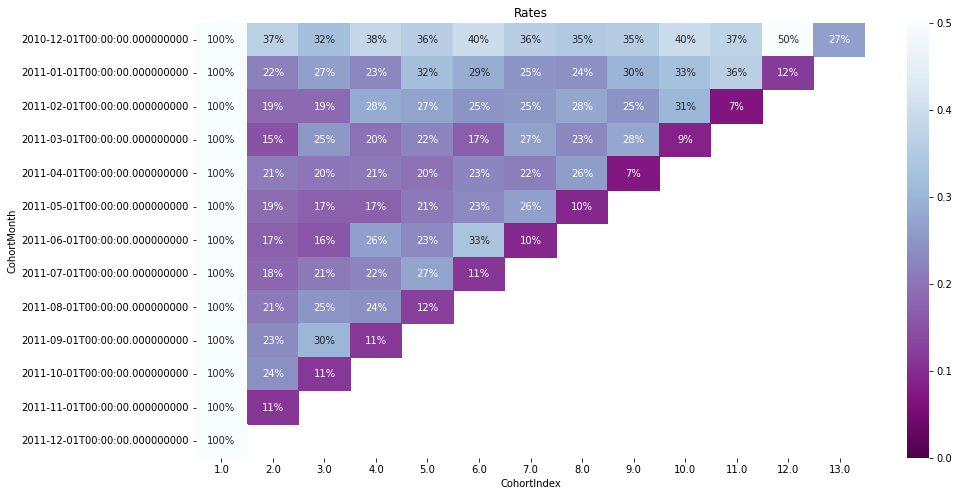

In [15]:
#building heat map
plt.figure(figsize=(15,8))
plt.title('Rates')
sn.heatmap(data=percentage,annot=True,fmt='.0%',vmin=0.0,vmax=0.5,cmap="BuPu_r")
plt.show()

Conclusion: 
above heatmap shows us a relative comparison between the cohert index and cohort month.
it shows how the customers have bought items after their 1st purchase each month

In [16]:
#avg quantiity for each cohort
group = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = group['Quantity'].mean()
cohort_data = cohort_data.reset_index()
#cohort_data
avg_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
avg_quantity.round(3)
avg_quantity

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.938105,15.573125,15.593027,15.760628,13.505140,14.815346,15.963274,15.504725,18.087810,17.575223,18.872942,13.387148,15.250758
2011-01-01,17.248347,13.321171,12.617637,15.145635,12.784335,15.272587,14.891156,14.846875,11.573576,10.512856,9.422452,9.956236,NaN
2011-02-01,11.107391,13.536119,19.025853,11.988019,12.280948,12.264561,13.539591,13.329562,10.852063,12.315682,13.390244,NaN,NaN
2011-03-01,9.903989,11.681596,13.266002,10.089765,14.292843,12.954137,13.399392,13.742945,11.169345,9.473896,NaN,NaN,NaN
2011-04-01,9.991433,10.390747,9.768454,11.846272,11.797654,8.588322,9.898109,9.479414,7.449331,NaN,NaN,NaN,NaN
2011-05-01,11.340957,9.625688,14.086245,12.757906,11.141816,8.686333,10.637374,109.930468,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.579657,14.528139,10.819328,13.549084,10.560726,9.815911,9.411483,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.837340,13.750499,7.307577,8.086257,6.120728,7.064639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.031295,6.173750,5.413478,6.153709,7.056730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


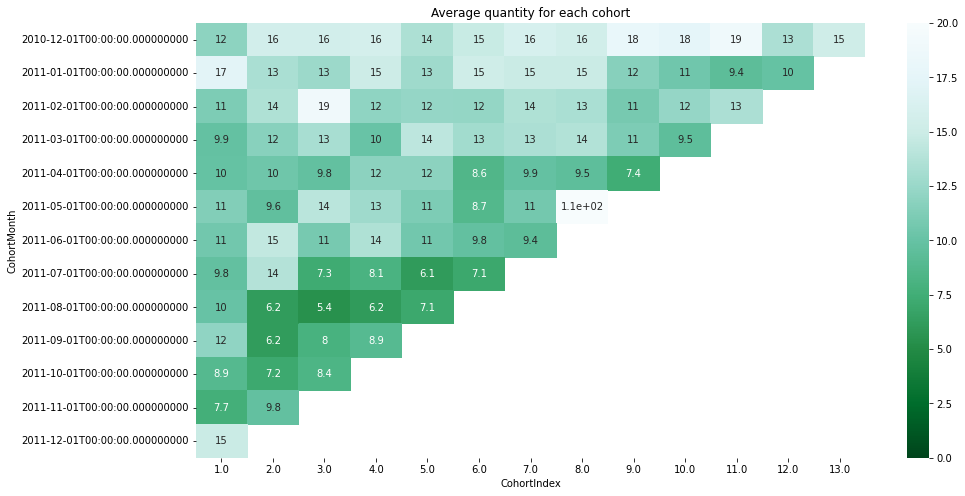

In [17]:
plt.figure(figsize=(15,8))
plt.title('Average quantity for each cohort')
sn.heatmap(data=avg_quantity, annot=True,vmin=0,vmax=20,cmap='BuGn_r')
plt.show()